In [1]:
location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sutils_praj' % location)
sys.path.append('%sNeuronalModelling/' % location)

# import statements
from brian2 import *
from funcs_pj import generate_new_color
import matplotlib.pyplot as plt
import numpy as np
from brian2_recurrentnet_seizures.brian2_utils import *
from brian2_recurrentnet_seizures.brian_recurrent_net_main import *

import pickle
import pandas as pd
import random


Welcome. This model is called ... rec_sz1


In [2]:
# create W matrix
inh_conn = 0.2
exc_conn = 0.02
E_prob = 0.90  # probability of excitatory cells (rest will be inhibitory)
Ntotal = 1000*5

# creating custom synaptic connectivity matrix for recurrent layer -- not quite a full synaptic weights matrix
Nn = Ntotal  # number of neurons in the recurrent layer
W = np.zeros([Nn, Nn])  # matrix of recurrent connection weights, should be a Nn x Nn size array
# W = np.diag(np.ones(Nn)) # -- self connections


###### spatially ordered connectivity
p_e = exc_conn  # probability of E->All connections
p_i = inh_conn  # probability of I->All connections neurons

Ne = random.sample(range(Nn), int(E_prob * Nn))
Ni = [x for x in range(Nn) if x not in Ne]

# need to intersperse E and I neurons throughout the whole cell population
for i in range(Nn):
    # select random indexes to setup as connections based on selected probability
    # set E --> all connectivity
    if i in Ne:
        j = [int(target) for target in np.random.normal(i, 200, int(p_e * len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

    # set I --> all connectivity
    elif i in Ni:
        j = [int(target) for target in np.random.normal(i, 200, int(p_i * len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

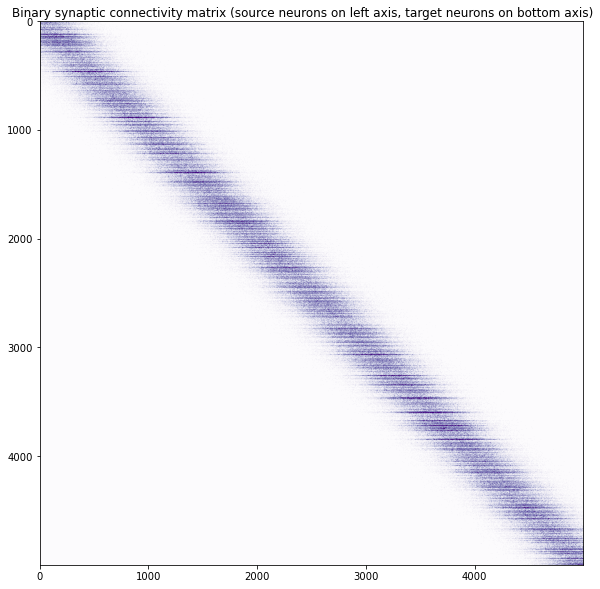

In [3]:
def plot_connectivity_matrix(conn_matrix, cmap='Purples', color_lim=[0.05, 0.1], colorbar=False):
    """plot heatmap of synaptic connectivity matrix given as numpy array where 1 denotes connection between i and j index"""
    # plt.figure(figsize=[10, 10])
    fig, ax = plt.subplots(figsize=(10, 10))

    ax = ax.imshow(conn_matrix, cmap=cmap, vmin=color_lim[0], vmax=color_lim[1])
#     plt.clim(color_lim[0], color_lim[1])
#     if title is not None:
#         ax.set_title(title)
    plt.suptitle('Binary synaptic connectivity matrix (source neurons on left axis, target neurons on bottom axis)', wrap=True, y = 0.90)
    if colorbar:
        plt.colorbar()
    plt.show()
    
plot_connectivity_matrix(W, color_lim=[0.0,0.51])

!STIMULATION ACTIVE!
|- Neurons specified for stim:  2626  to  2370
|- stim length:  0.999 s


WARNING    "i" is an internal variable of group "neurongroup", but also exists in the run namespace with the value array([  0,   0,   0, ..., 499, 499, 499]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 3. s
215.8 ms (7%) simulated in 10s, estimated 2m 9s remaining.
0.4156 s (13%) simulated in 20s, estimated 2m 4s remaining.
0.6156 s (20%) simulated in 30s, estimated 1m 56s remaining.
0.8158 s (27%) simulated in 40s, estimated 1m 47s remaining.
1.0153 s (33%) simulated in 50s, estimated 1m 38s remaining.
1.2151 s (40%) simulated in 1m 0s, estimated 1m 28s remaining.
1.4152 s (47%) simulated in 1m 10s, estimated 1m 18s remaining.
1.6145 s (53%) simulated in 1m 20s, estimated 1m 9s remaining.
1.8145 s (60%) simulated in 1m 30s, estimated 59s remaining.
2.0134 s (67%) simulated in 1m 40s, estimated 49s remaining.
2.2135 s (73%) simulated in 1m 50s, estimated 39s remaining.
2.4137 s (80%) simulated in 2m 0s, estimated 29s remaining.
2.6132 s (87%) simulated in 2m 10s, estimated 19s remaining.
2.8134 s (93%) simulated in 2m 20s, estimated 9s remaining.
3. s (100%) simulated in 2m 29s
30 neurons stimulated


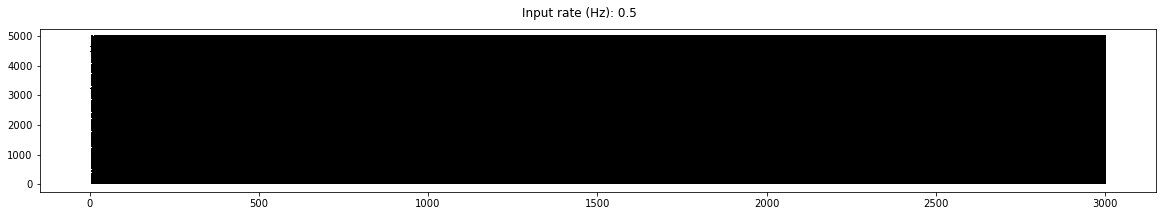

average spiking rate of population:  497.2 Hz
collected binned spikes rasters...


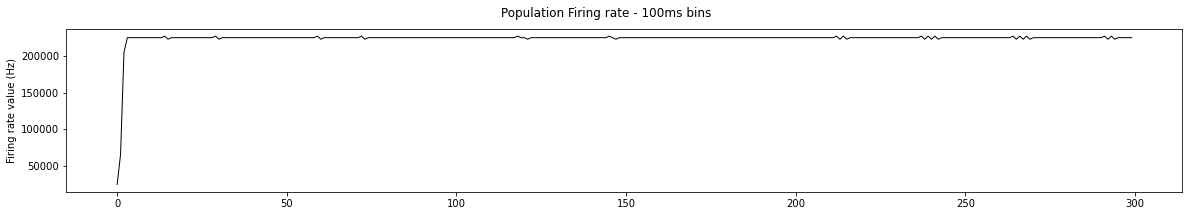

(4500, 300)
!STIMULATION ACTIVE!
|- Neurons specified for stim:  2626  to  2370
|- stim length:  0.999 s


WARNING    "i" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value array([  0,   0,   0, ..., 499, 499, 499]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "dt" is an internal variable of group "poissongroup_1", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 3. s
215.4 ms (7%) simulated in 10s, estimated 2m 9s remaining.
0.4167 s (13%) simulated in 20s, estimated 2m 4s remaining.
0.6183 s (20%) simulated in 30s, estimated 1m 56s remaining.
0.8196 s (27%) simulated in 40s, estimated 1m 46s remaining.
1.0212 s (34%) simulated in 50s, estimated 1m 37s remaining.
1.2227 s (40%) simulated in 1m 0s, estimated 1m 27s remaining.
1.4244 s (47%) simulated in 1m 10s, estimated 1m 17s remaining.
1.6253 s (54%) simulated in 1m 20s, estimated 1m 8s remaining.
1.8266 s (60%) simulated in 1m 30s, estimated 58s remaining.
2.0282 s (67%) simulated in 1m 40s, estimated 48s remaining.
2.2294 s (74%) simulated in 1m 50s, estimated 38s remaining.
2.4306 s (81%) simulated in 2m 0s, estimated 28s remaining.
2.6324 s (87%) simulated in 2m 10s, estimated 18s remaining.
2.834 s (94%) simulated in 2m 20s, estimated 8s remaining.
3. s (100%) simulated in 2m 28s
30 neurons stimulated


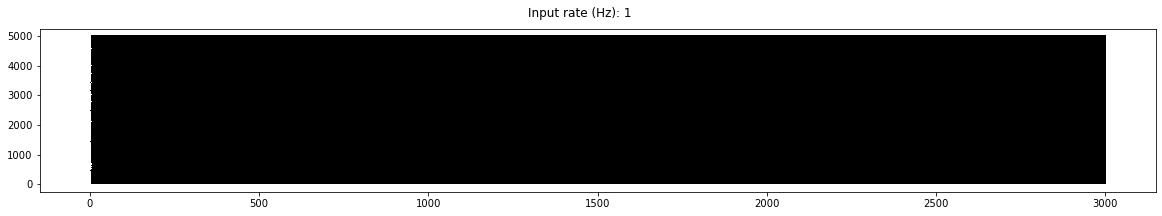

average spiking rate of population:  497.46 Hz
collected binned spikes rasters...


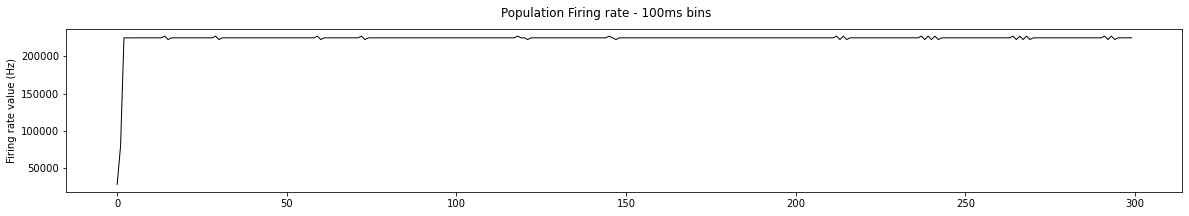

(4500, 300, 2)
!STIMULATION ACTIVE!
|- Neurons specified for stim:  2626  to  2370
|- stim length:  0.999 s
Starting simulation at t=0. s for a duration of 3. s
205.8 ms (6%) simulated in 10s, estimated 2m 16s remaining.
0.4028 s (13%) simulated in 20s, estimated 2m 9s remaining.
0.5998 s (19%) simulated in 30s, estimated 2m 0s remaining.
0.7965 s (26%) simulated in 40s, estimated 1m 51s remaining.
0.9932 s (33%) simulated in 50s, estimated 1m 41s remaining.
1.1902 s (39%) simulated in 1m 0s, estimated 1m 31s remaining.
1.3867 s (46%) simulated in 1m 10s, estimated 1m 21s remaining.
1.5834 s (52%) simulated in 1m 20s, estimated 1m 12s remaining.
1.7799 s (59%) simulated in 1m 30s, estimated 1m 2s remaining.
1.9768 s (65%) simulated in 1m 40s, estimated 52s remaining.
2.1733 s (72%) simulated in 1m 50s, estimated 42s remaining.
2.3697 s (78%) simulated in 2m 0s, estimated 32s remaining.
2.5665 s (85%) simulated in 2m 10s, estimated 22s remaining.
2.7618 s (92%) simulated in 2m 20s, esti

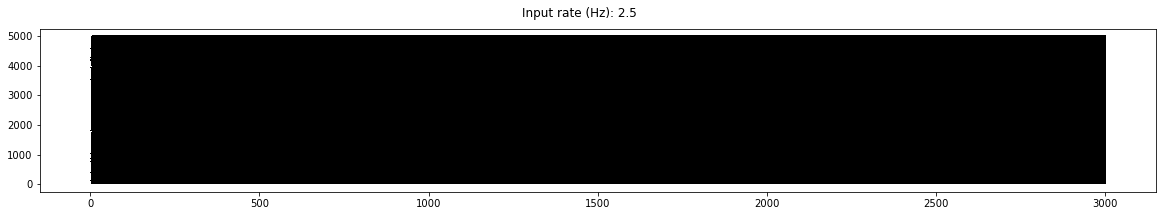

average spiking rate of population:  498.51 Hz
collected binned spikes rasters...


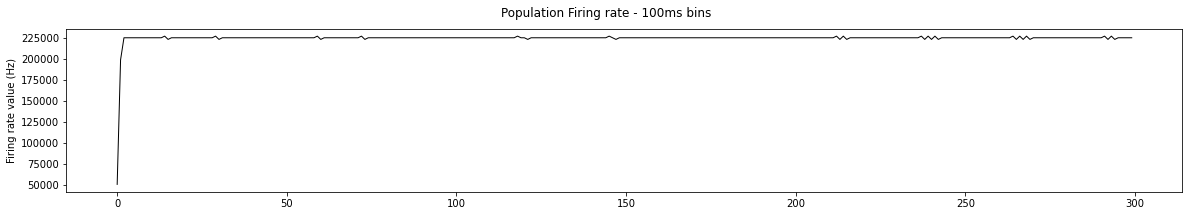

(4500, 300, 3)


In [4]:
#%% BUILD AND RUN NETWORK

#### set some network parameters
runtime = 3*second
dt = 0.1*ms
neurons_to_stim = Ne[20:50]
stim_external = True
w_matrix = None


#### build and run simulation
spike_raster_binned_multi = None
for input_rate in [0.5, 1, 2.5]:
    # build network
    record_id=[Ne[0], Ne[100], Ni[23], Ni[65]]
    net, W, trace, s_mon, trace_ge, s_mon_p, Ce, Ci, Ge, Gi, G, trace_z, trace_gi, trace_gi_diff = \
    build_network(Ntotal=Ntotal, record_id=record_id, runtime = runtime, inh_conn=inh_conn, input_rate=input_rate, stim_external = stim_external, neurons_to_stim = neurons_to_stim, Ne = Ne, Ni = Ni,
                  w_matrix = w_matrix)
        
    if stim_external:
        print('%s neurons stimulated' % len(neurons_to_stim))

    # quick spike raster plot to initialize plotting
    figure(figsize=[20,3])
    plot(s_mon.t/ms, s_mon.i, ',k')
    plt.suptitle('Input rate (Hz): %s' % (input_rate))
#     plt.suptitle(title)
    plt.show()
    spike_counts = s_mon.count
    spike_counts_Hz = array(spike_counts/runtime)
    avg=mean(spike_counts_Hz); print('average spiking rate of population: ', np.round(avg, 2), 'Hz')
    
    
    
    # make spike raster bins
    spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

    spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in Ne]

    # create numpy array of spikes:
    spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=100)
    plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 100ms bins')

    if spike_raster_binned_multi is None:
        spike_raster_binned_multi = spike_raster_binned
        print(spike_raster_binned_multi.shape)
    else:
        spike_raster_binned_multi = np.dstack((spike_raster_binned_multi, spike_raster_binned))
        print(spike_raster_binned_multi.shape)


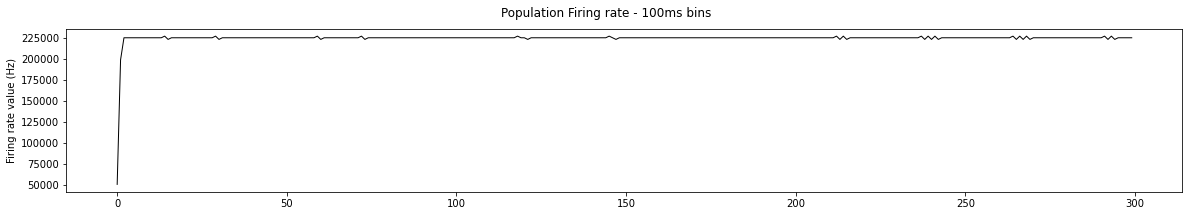

In [5]:
plot_firing_rate(spike_raster_binned_multi[:,:,2], binsize_sec=0.1, title='Population Firing rate - 100ms bins')

0
[[2. 5. 5. ... 5. 5. 5.]
 [0. 1. 4. ... 5. 5. 5.]
 [2. 1. 5. ... 5. 5. 5.]
 ...
 [1. 0. 4. ... 5. 5. 5.]
 [0. 0. 4. ... 5. 5. 5.]
 [1. 0. 4. ... 5. 5. 5.]]


WARNING    <ipython-input-6-978a213e52ce>:27: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


LinregressResult(slope=-4.541855973792714, intercept=-23.023636035597004, rvalue=-0.5845135966618283, pvalue=6.098664501257503e-07, stderr=0.8139345958103729, intercept_stderr=3.9229784663778466)


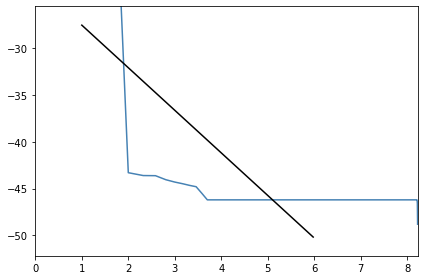

1
[[0. 0. 5. ... 5. 5. 5.]
 [1. 5. 5. ... 5. 5. 5.]
 [0. 0. 5. ... 5. 5. 5.]
 ...
 [1. 0. 5. ... 5. 5. 5.]
 [0. 1. 5. ... 5. 5. 5.]
 [0. 1. 5. ... 5. 5. 5.]]


WARNING    <ipython-input-6-978a213e52ce>:27: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


LinregressResult(slope=-4.340729646009179, intercept=-24.155682298856, rvalue=-0.5767330182584657, pvalue=9.293106801952424e-07, stderr=0.7937771141716364, intercept_stderr=3.825824018327339)


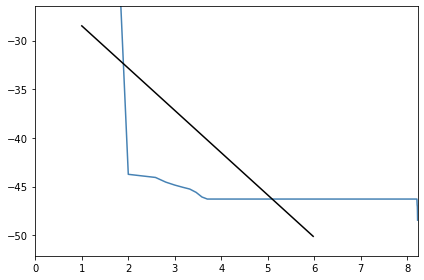

2
[[0. 4. 5. ... 5. 5. 5.]
 [1. 5. 5. ... 5. 5. 5.]
 [1. 4. 5. ... 5. 5. 5.]
 ...
 [1. 4. 5. ... 5. 5. 5.]
 [3. 5. 5. ... 5. 5. 5.]
 [0. 4. 5. ... 5. 5. 5.]]


WARNING    <ipython-input-6-978a213e52ce>:27: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


LinregressResult(slope=-2.7718443672915116, intercept=-32.63908809023315, rvalue=-0.4963413216147985, pvalue=4.082776344928696e-05, stderr=0.6258875019077982, intercept_stderr=3.0166345121560005)


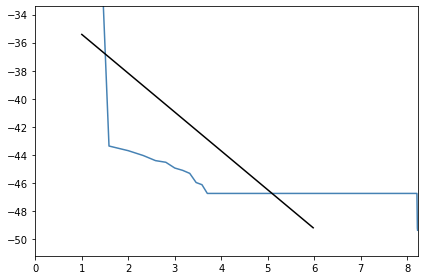

In [6]:
# PCA analysis
for i in range(3):
    print(i)
    spike_raster_binned = spike_raster_binned_multi[:,:,i]
    print(spike_raster_binned)
    pca = PCA(n_components=min(spike_raster_binned.shape))
    pca.fit(spike_raster_binned)
    pca_result = pd.DataFrame(pca.transform(spike_raster_binned))  # , columns=['PCA%i' % i for i in range(275)])
    sv = pca.singular_values_
    su = (sv / sum(sv))

    data = pca.explained_variance_ratio_
    data = sv

    subset = [2**1, 2**6]

    # fit and plot variance per PC

    x = range(len(data))[subset[0]:subset[1]]
    y = data[subset[0]:subset[1]]

    # to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
    res = stats.linregress(np.log2(x), np.log2(y))
    print(res)

    x_full = range(len(data))
    plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
    plt.plot(np.log2(x), res.intercept + res.slope * np.log2(x), c = 'black', label='fitted line')
    plt.ylim(min(res.intercept + res.slope * np.log2(x)) - 2, max(res.intercept + res.slope * np.log2(x)) + 2)
    plt.margins(x=0)
    plt.tight_layout()
    plt.show()


In [7]:
G.equations

gi_diff = (-gi + gi_t)/factor : radian
z_inf = 1.0/(1.0 + exp(-2.0*gi_diff)) : radian
dV/dt = 1.0*(gL*(-V + Vl) + ge*(Ee - V) + gi*z*(Ei - V) + stimulus(t, i))*int_(not_refractory)/Cm : volt (unless refractory)
dge/dt = -ge/tau_d : siemens
dgi/dt = -gi/tau_d : siemens
dz/dt = 1.0*(-z + z_inf)/tau_g : radian
lastspike : second
not_refractory : radian


collected binned spikes rasters...


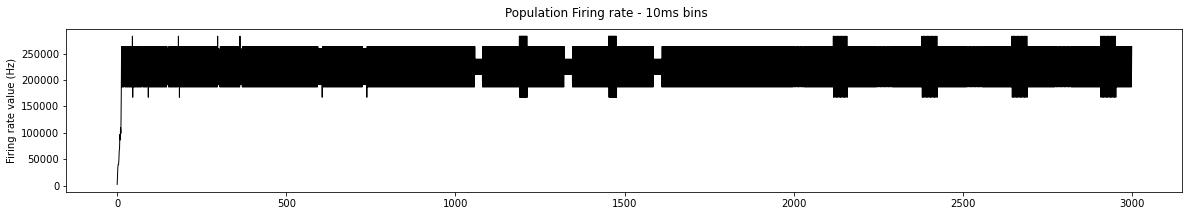

collected binned spikes rasters...


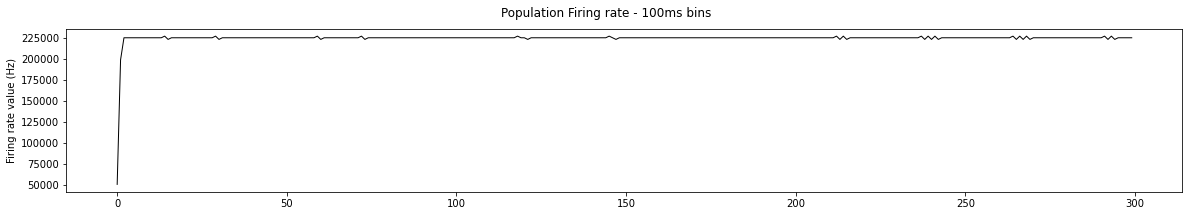

In [8]:
spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in Ne]

# create numpy array of spikes:
spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=10)
plot_firing_rate(spike_raster_binned, binsize_sec=0.01, title='Population Firing rate - 10ms bins')

spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=100)
plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 100ms bins')



WARNING    <ipython-input-9-1b1c19dde8cc>:25: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


LinregressResult(slope=-0.1660765604605682, intercept=-45.58409542718707, rvalue=-0.5023678207538835, pvalue=2.47620712723078e-20, stderr=0.016670753435839812, intercept_stderr=0.11626933918231176)


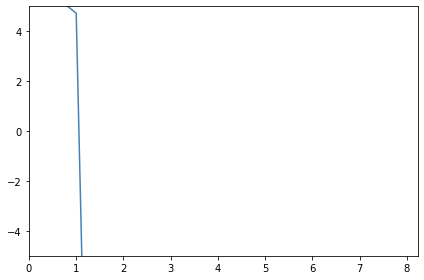

In [9]:
# PCA and powerlaw fit of the eigen decomposition


pca = PCA(n_components=min(spike_raster_binned.shape))
pca.fit(spike_raster_binned)
pca_result = pd.DataFrame(pca.transform(spike_raster_binned))  # , columns=['PCA%i' % i for i in range(275)])
sv = pca.singular_values_
su = (sv / sum(sv))

data = pca.explained_variance_ratio_
data = sv

subset = [2**2,2**9]

# fit and plot variance per PC

x = range(len(data))[subset[0]:subset[1]]
y = data[subset[0]:subset[1]]

# to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
res = stats.linregress(np.log2(x), np.log2(y))
print(res)

x_full = range(len(data))
plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
plt.plot(np.log2(x), res.intercept + res.slope * np.log2(x), c = 'black', label='fitted line')
plt.ylim(-5, 5)
plt.margins(x=0)
plt.tight_layout()
plt.show()



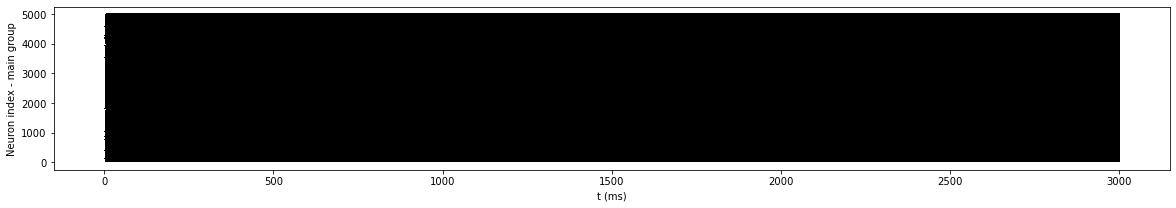

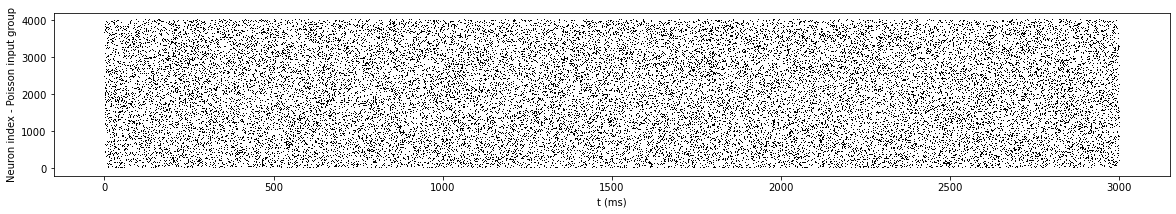

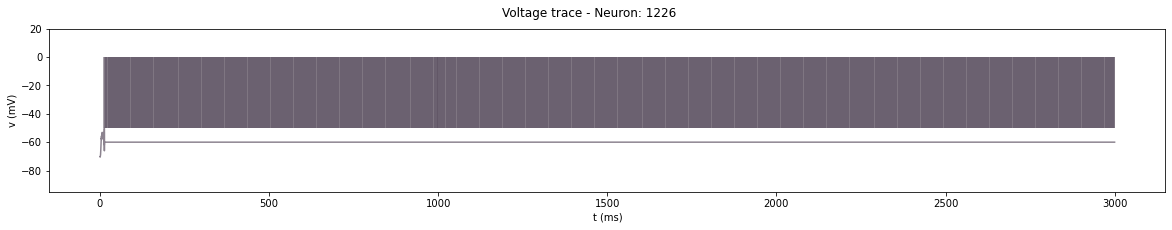

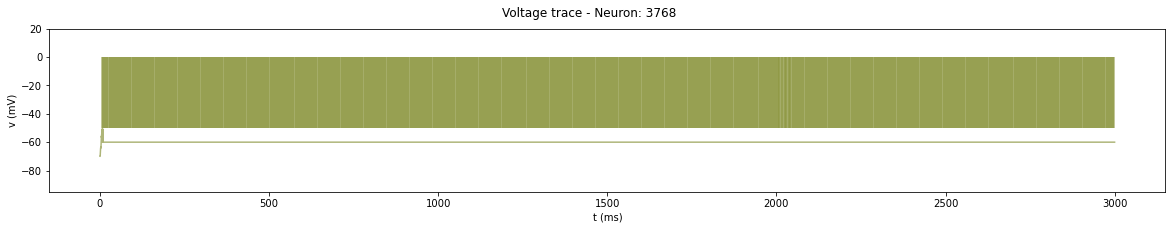

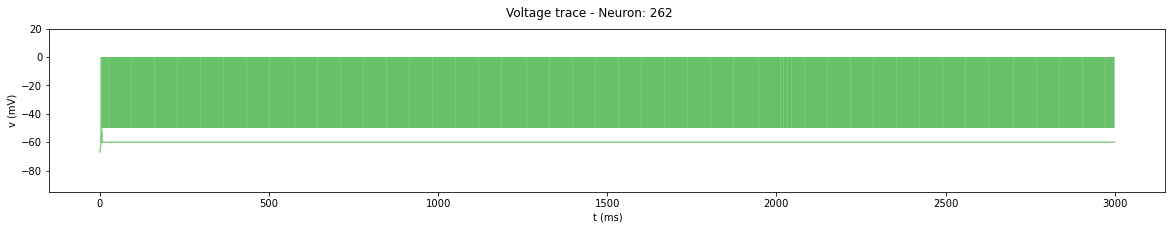

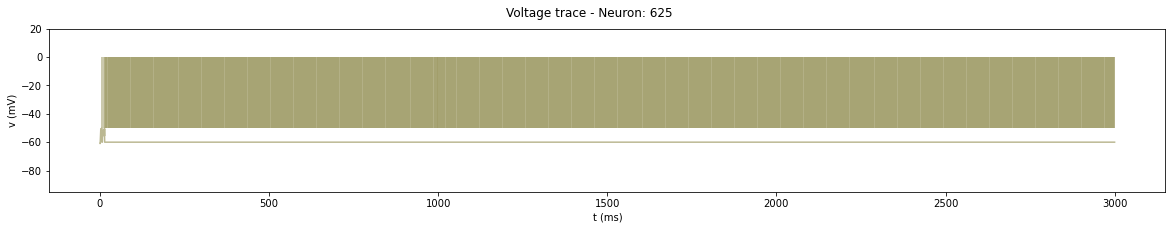

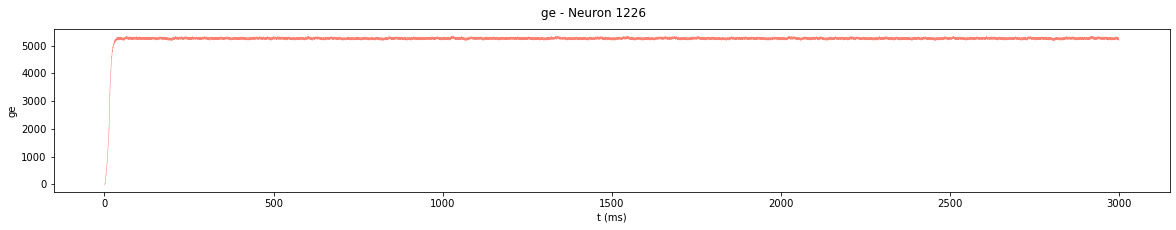

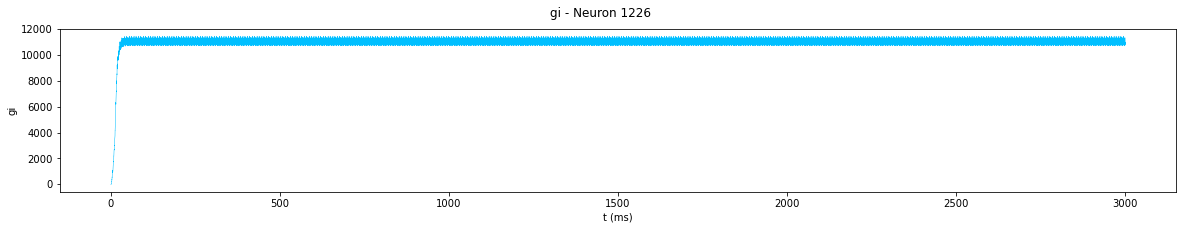

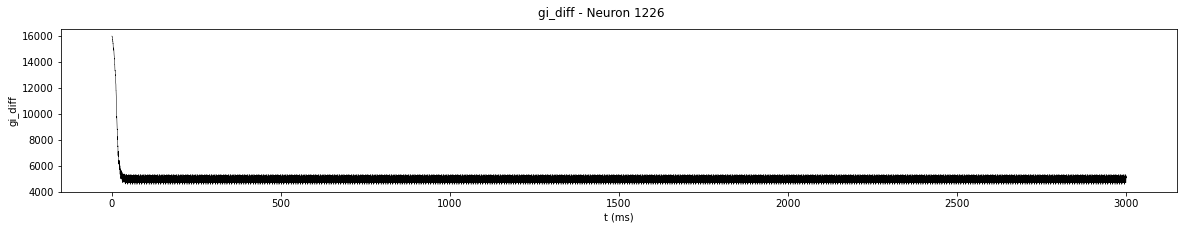

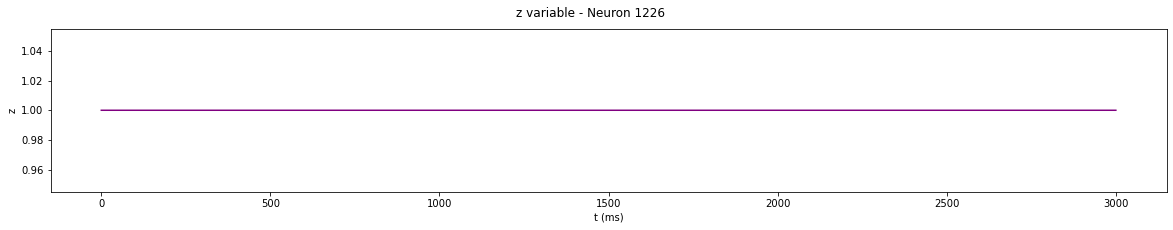

In [10]:
make_plots_inh_exhaust_mech(s_mon, s_mon_p, trace, trace_z, trace_gi_diff, trace_gi, trace_ge, neuron=[Ne[0], Ne[100], Ni[23], Ni[65]])


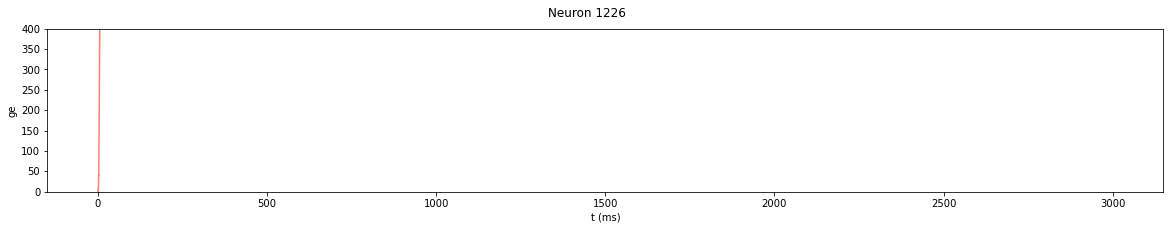

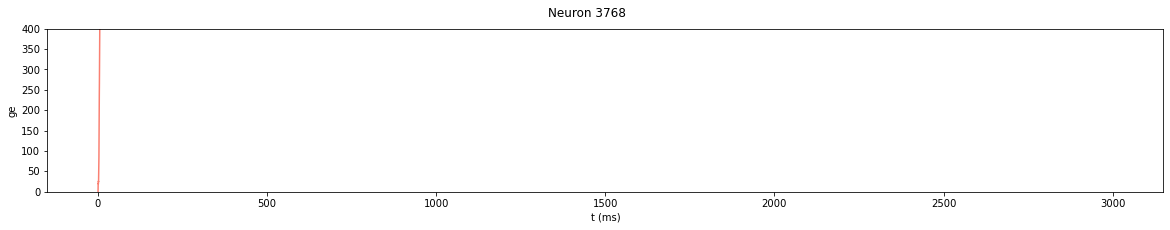

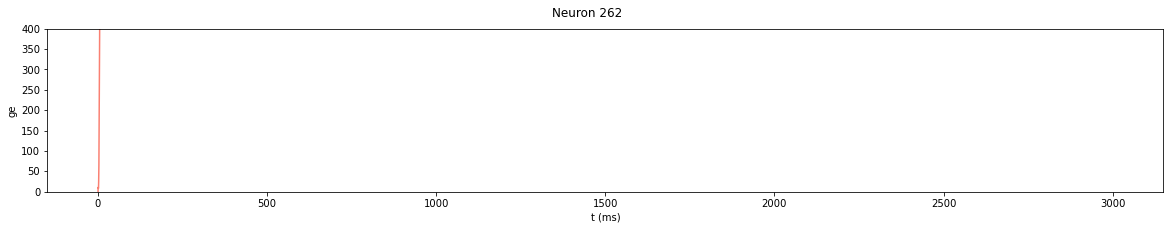

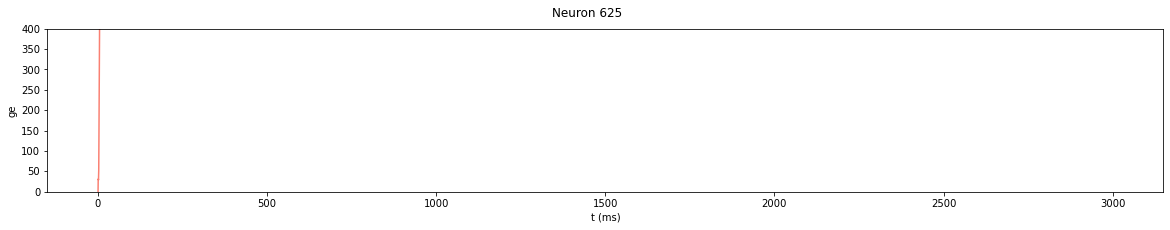

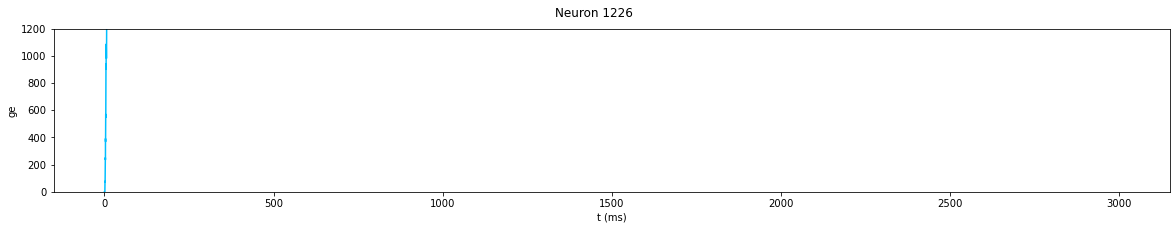

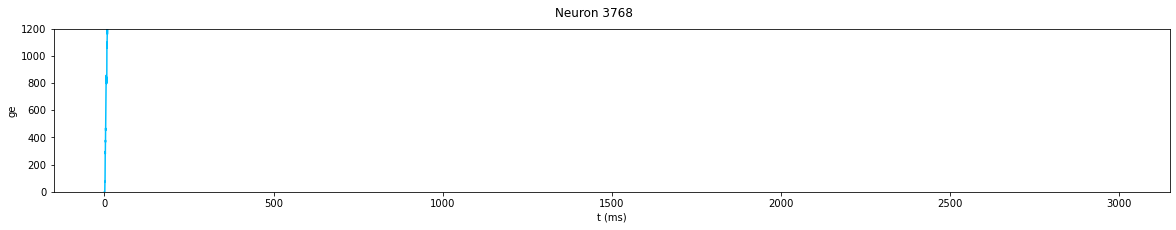

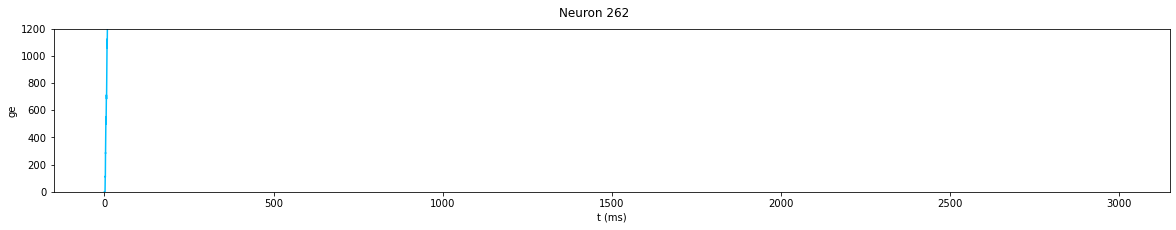

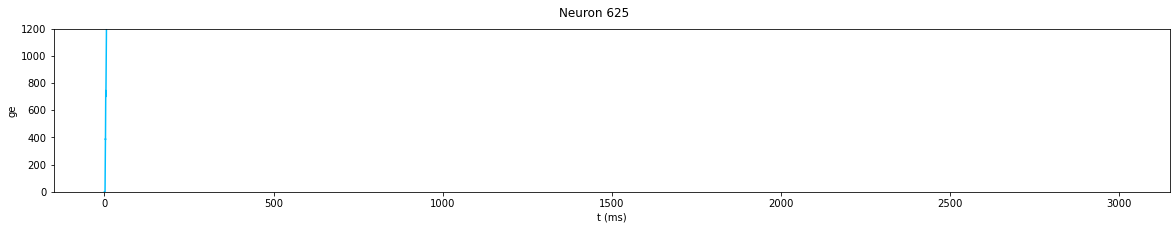

In [11]:
for neuron in record_id:
    plt.figure(figsize=[20, 3])
    plot(trace_ge.t / ms, trace_ge[neuron].ge / nS, c='salmon')
    suptitle('Neuron %s' % neuron)
    xlabel('t (ms)')
    ylim([0,400])
    ylabel('ge')
    show()
    
for neuron in record_id:
    plt.figure(figsize=[20, 3])
    plot(trace_gi.t / ms, trace_gi[neuron].gi / nS, c='deepskyblue')
    suptitle('Neuron %s' % neuron)
    xlabel('t (ms)')
    ylim([0,1200])
    ylabel('ge')
    show()

In [12]:
# reset -f

0.9497561904968778


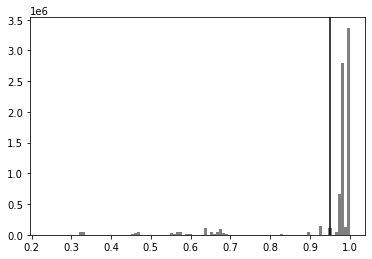

In [13]:
#%% calculate correlation coefficients
corr_mtx = np.corrcoef(spike_raster_binned[:int(Ntotal*0.8),:])
x = corr_mtx[np.triu_indices(corr_mtx.shape[0], k=1)]
# not sure why but there are nan values coming up in the corr_values calculation
# remove nans from corr_values

corr_values = x[~np.isnan(x)]
avg_corr = np.mean(corr_values)
print(np.mean(corr_values))

plt.hist(corr_values, bins=100, color='gray')
plt.axvline(x=avg_corr, color='black')
plt.show()

In [14]:
#%% calculate correlation of the subthreshold membrane potential
trace_array = [trace_ge[x].ge/mvolt for x in record_id]

corr_mtx = np.corrcoef(trace_array)
x = corr_mtx[np.triu_indices(corr_mtx.shape[0], k=1)]
avg_corr = np.mean(x)
print(avg_corr)

0.9942203954841459


In [15]:
corr_mtx

array([[1.        , 0.99570335, 0.99695906, 0.9950238 ],
       [0.99570335, 1.        , 0.99245207, 0.99254647],
       [0.99695906, 0.99245207, 1.        , 0.99263762],
       [0.9950238 , 0.99254647, 0.99263762, 1.        ]])

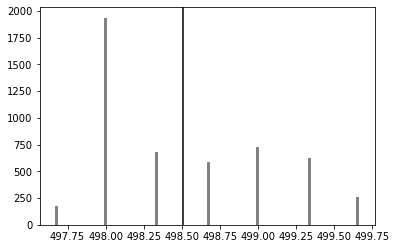

In [16]:
plt.hist(spike_counts_Hz, bins=100, color='gray')
plt.axvline(x=avg, color='black')
plt.show()

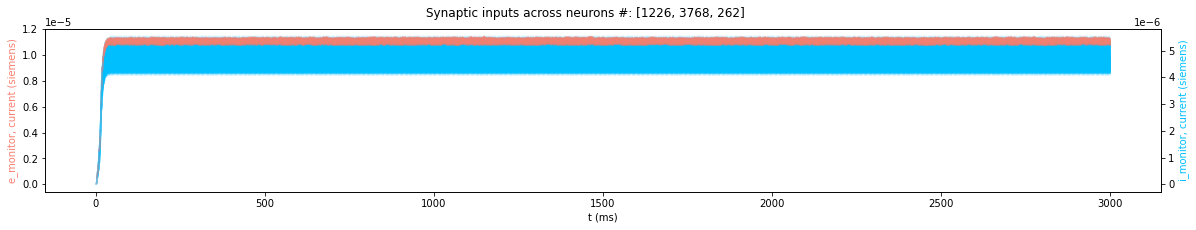

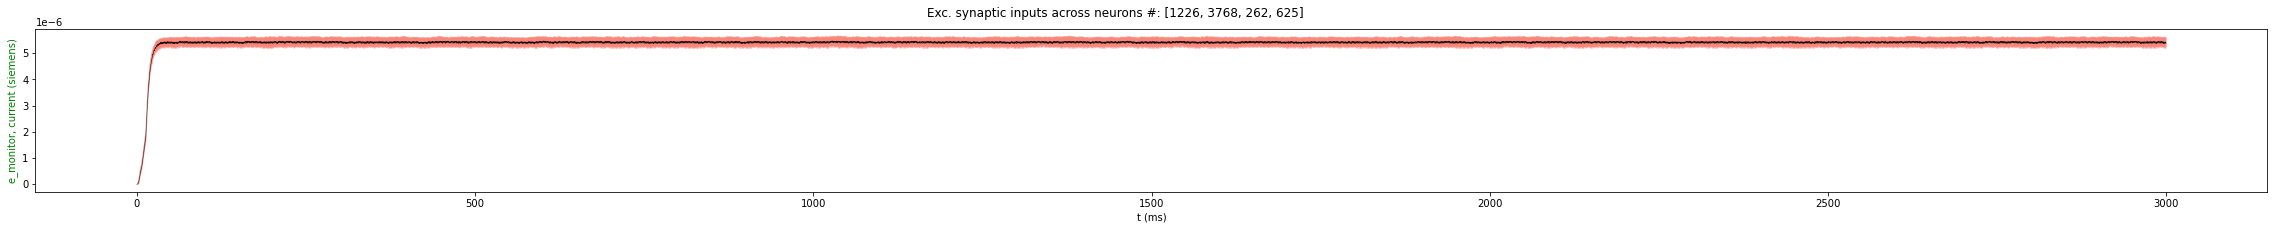

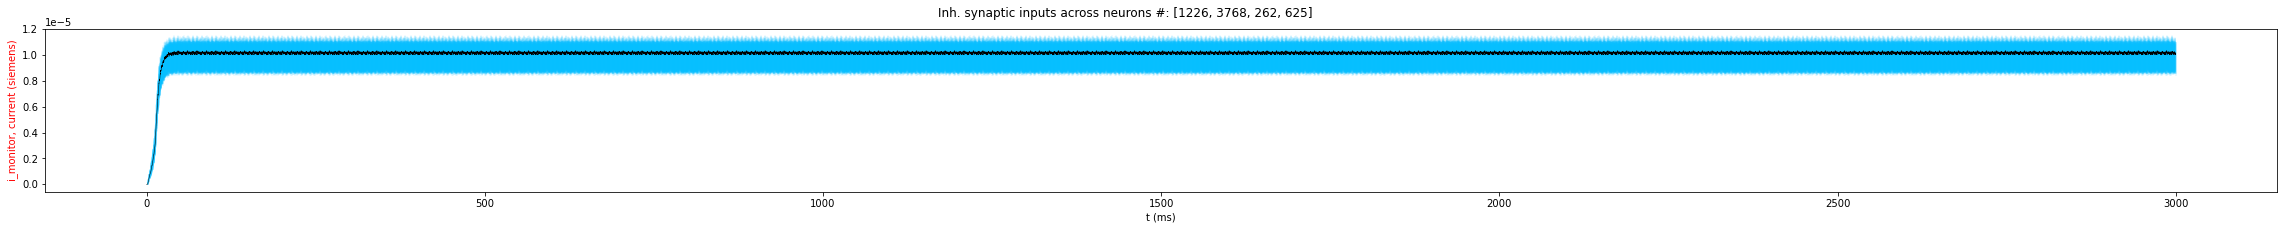

In [17]:
plot_inputs(e_monitor=trace_ge, i_monitor=trace_gi, neurons_to_plot=record_id[:3], alpha=0.1)
plot_e_inputs(e_monitor=trace_ge, neurons_to_plot=record_id, alpha=0.1)
plot_i_inputs(i_monitor=trace_gi, neurons_to_plot=record_id, alpha=0.1)